# Explore data

In [1]:
import os, sys
import math
import hydra
import pydicom
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from omegaconf import DictConfig, OmegaConf

In [2]:
print(os.getcwd())

/media/mountHDD1/users/duong/git/MultiphaseBioImgGen/src/datasets/vindr_multiphase


In [3]:
_root = "/".join(os.getcwd().split("/")[:-3])
print(os.listdir(_root))

['wandb', '.gitignore', 'results', 'src', 'LICENSE', 'README.md', '.git', 'configs', 'data']


In [4]:
dataset_dir = _root + "/data/vindr_multiphase"
print(os.listdir(dataset_dir))

['metadata.csv', 'metadata_prompt.csv', 't5_embeddings', 'abdomen_phases']


In [5]:
label_df = pd.read_csv(dataset_dir + "/abdomen_phases/labels.csv")
label_df.head(5)

,StudyInstanceUID,SeriesInstanceUID,Label
0,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,Non-contrast
1,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,Aterial
2,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,Venous
3,1.2.392.200036.9116.2.5.1.37.2418751871.149792...,1.2.392.200036.9116.2.5.1.37.2418751871.149792...,Non-contrast
4,1.2.392.200036.9116.2.5.1.37.2418751871.149792...,1.2.392.200036.9116.2.5.1.37.2418751871.149792...,Aterial


In [6]:
metadata = dataset_dir + "/metadata.csv"
df = pd.read_csv(metadata, low_memory=False)
df.head(5)

,image_path,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,PatientSex,PatientAge,PatientWeight,BodyPartExamined,Modality,ScanOptions,InstanceNumber,SliceLocation,ContrastBolusAgent,ContrastBolusStartTime,ImageOrientationPatient,PixelSpacing,SliceThickness
0,./data/vindr_multiphase/abdomen_phases/batch6/...,1.2.840.113619.2.359.3.2831208971.49.155787871...,1.2.840.113619.2.359.3.2831208971.49.155787871...,1.2.840.113619.2.359.3.2831208971.49.155787871...,M,000Y,NaN,NaN,CT,HELICAL MODE,23,-132.5,NaN,NaN,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...","[0.619141, 0.619141]",5.0
1,./data/vindr_multiphase/abdomen_phases/batch6/...,1.2.840.113619.2.359.3.2831208971.49.155787871...,1.2.840.113619.2.359.3.2831208971.49.155787871...,1.2.840.113619.2.359.3.2831208971.49.155787871...,M,000Y,NaN,NaN,CT,HELICAL MODE,17,-102.5,NaN,NaN,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...","[0.619141, 0.619141]",5.0
2,./data/vindr_multiphase/abdomen_phases/batch6/...,1.2.840.113619.2.359.3.2831208971.49.155787871...,1.2.840.113619.2.359.3.2831208971.49.155787871...,1.2.840.113619.2.359.3.2831208971.49.155787871...,M,000Y,NaN,NaN,CT,HELICAL MODE,14,-87.5,NaN,NaN,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...","[0.619141, 0.619141]",5.0
3,./data/vindr_multiphase/abdomen_phases/batch6/...,1.2.840.113619.2.359.3.2831208971.49.155787871...,1.2.840.113619.2.359.3.2831208971.49.155787871...,1.2.840.113619.2.359.3.2831208971.49.155787871...,M,000Y,NaN,NaN,CT,HELICAL MODE,3,-32.5,NaN,NaN,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...","[0.619141, 0.619141]",5.0
4,./data/vindr_multiphase/abdomen_phases/batch6/...,1.2.840.113619.2.359.3.2831208971.49.155787871...,1.2.840.113619.2.359.3.2831208971.49.155787871...,1.2.840.113619.2.359.3.2831208971.49.155787871...,M,000Y,NaN,NaN,CT,HELICAL MODE,5,-42.5,NaN,NaN,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...","[0.619141, 0.619141]",5.0


In [7]:
merged_df = pd.merge(df, label_df, on=['StudyInstanceUID', 'SeriesInstanceUID'], how='outer')
print(merged_df.shape)

(392560, 18)


In [8]:
merged_df["PatientAge"] = merged_df["PatientAge"].replace({'58': '058Y', '52': '052Y'})
cleaned_df = merged_df.copy()
cleaned_df['Label'] = cleaned_df['Label'].str.replace('Non-contrast', 'Non contrast').str.replace('Aterial', 'Arterial')
# cleaned_df['Label'] = cleaned_df['Label'].map({'Non-contrast': 'Non contrast', 'Aterial': 'Arterial'}).astype("str")
cleaned_df['PatientSex'] = cleaned_df['PatientSex'].map({'M': 'male', 'F': 'female'})
cleaned_df['PatientAge'] = cleaned_df['PatientAge'].str.replace('Y', '').str.lstrip('0')

cleaned_df = cleaned_df.dropna(subset=['PatientSex']).reset_index(drop=True) 
cleaned_df = cleaned_df.dropna(subset=['PatientWeight']).reset_index(drop=True) 
print(cleaned_df.shape)
cleaned_df.head()

(148433, 18)


,image_path,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,PatientSex,PatientAge,PatientWeight,BodyPartExamined,Modality,ScanOptions,InstanceNumber,SliceLocation,ContrastBolusAgent,ContrastBolusStartTime,ImageOrientationPatient,PixelSpacing,SliceThickness,Label
0,./data/vindr_multiphase/abdomen_phases/batch1/...,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,male,56,55.0,ABDOMEN,CT,HELICAL_CT,517,154.8,NaN,NaN,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[0.782, 0.782]",0.5,Non contrast
1,./data/vindr_multiphase/abdomen_phases/batch1/...,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,male,56,55.0,ABDOMEN,CT,HELICAL_CT,1026,307.5,NaN,NaN,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[0.782, 0.782]",0.5,Non contrast
2,./data/vindr_multiphase/abdomen_phases/batch1/...,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,male,56,55.0,ABDOMEN,CT,HELICAL_CT,94,27.9,NaN,NaN,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[0.782, 0.782]",0.5,Non contrast
3,./data/vindr_multiphase/abdomen_phases/batch1/...,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,male,56,55.0,ABDOMEN,CT,HELICAL_CT,846,253.5,NaN,NaN,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[0.782, 0.782]",0.5,Non contrast
4,./data/vindr_multiphase/abdomen_phases/batch1/...,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,1.2.392.200036.9116.2.5.1.37.2418751871.143269...,male,56,55.0,ABDOMEN,CT,HELICAL_CT,449,134.4,NaN,NaN,"[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...","[0.782, 0.782]",0.5,Non contrast


In [9]:
print(cleaned_df["Label"].value_counts())

Label
Venous          51643
Non contrast    49132
Arterial        47658
Name: count, dtype: int64


# Create Prompts

In [10]:
def create_prompt(result):
    prompt = (
        f"A high resolution CT scan of a {result['PatientSex']} patient, "
        f"{result['PatientAge']} years old, "
        f"weighing {result['PatientWeight']} kg, "
        f"instance {result['InstanceNumber']}, "
        f"with slice location at {result['SliceLocation']}mm, "
        f"captured in the {result['Label'].lower()} phase"
    )
    if pd.notna(result.get("ContrastBolusAgent")):
        prompt += f", performed with contrast enhancement injection"
    prompt += "."
    return prompt

cleaned_df['prompt'] = cleaned_df.apply(create_prompt, axis=1)
print(cleaned_df.shape)

(148433, 19)


In [11]:
print(cleaned_df["prompt"][120000])

A high resolution CT scan of a male patient, 79 years old, weighing 60.0 kg, instance 1405, with slice location at 391.2mm, captured in the arterial phase, performed with contrast enhancement injection.


In [12]:
cleaned_df.to_csv(dataset_dir + "/metadata_prompt.csv", index=False)

In [13]:
metadata_prompt = dataset_dir + "/metadata_prompt.csv"
metadata_prompt_df = pd.read_csv(metadata_prompt, low_memory=False)
metadata_prompt_df.head(5)
print(metadata_prompt_df.shape)

(148433, 19)


In [14]:
texts_unique_list = metadata_prompt_df["prompt"].tolist()
print(len(texts_unique_list))

148433


In [15]:
print(metadata_prompt_df["prompt"][100])

A high resolution CT scan of a male patient, 56 years old, weighing 55.0 kg, instance 55, with slice location at 16.2mm, captured in the non contrast phase.


# Visualize

In [16]:
sys.path.append(os.path.abspath("/media/mountHDD1/users/duong/git/MultiphaseBioImgGen"))
from src.datasets.vindr_multiphase.vindr_multiphase import convert_pixel_to_hu, apply_window

/media/mountHDD1/users/duong/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:datasets:PyTorch version 2.6.0 available.


Image: ./data/vindr_multiphase/abdomen_phases/batch1/1.2.392.200036.9116.2.5.1.37.2418751871.1432695579.168588/1.2.392.200036.9116.2.5.1.37.2418751871.1432695767.136800/1.2.392.200036.9116.2.5.1.37.2418751871.1432695837.131143.dcm
  WindowCenter: 40
  WindowWidth: 400


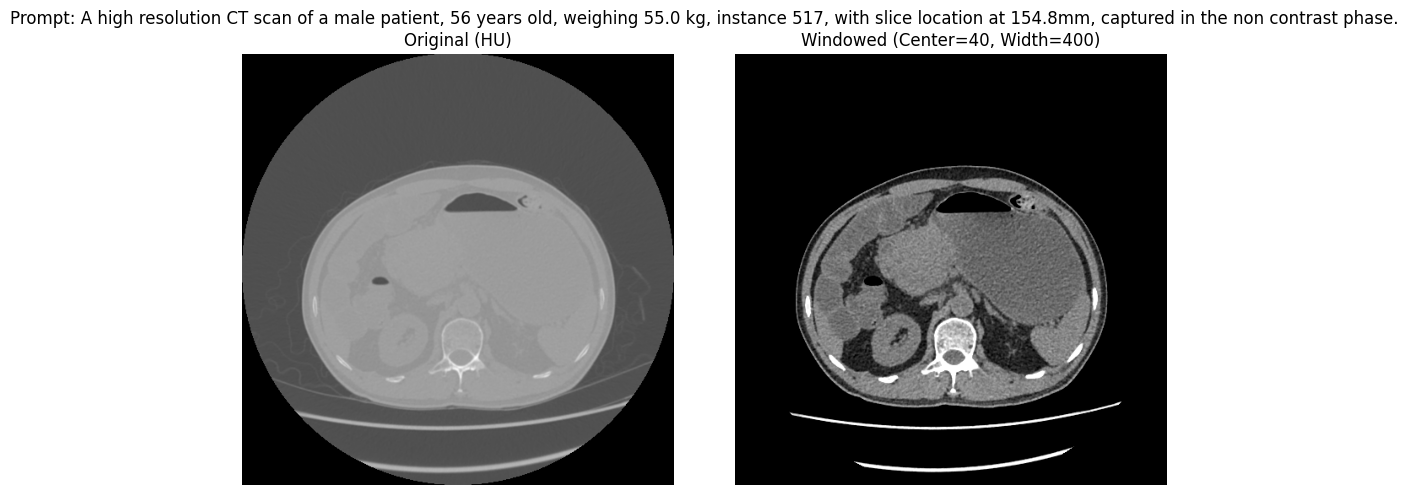

Image: ./data/vindr_multiphase/abdomen_phases/batch1/1.2.392.200036.9116.2.5.1.37.2418751871.1432695579.168588/1.2.392.200036.9116.2.5.1.37.2418751871.1432695767.136800/1.2.392.200036.9116.2.5.1.37.2418751871.1432695970.678407.dcm
  WindowCenter: 40
  WindowWidth: 400


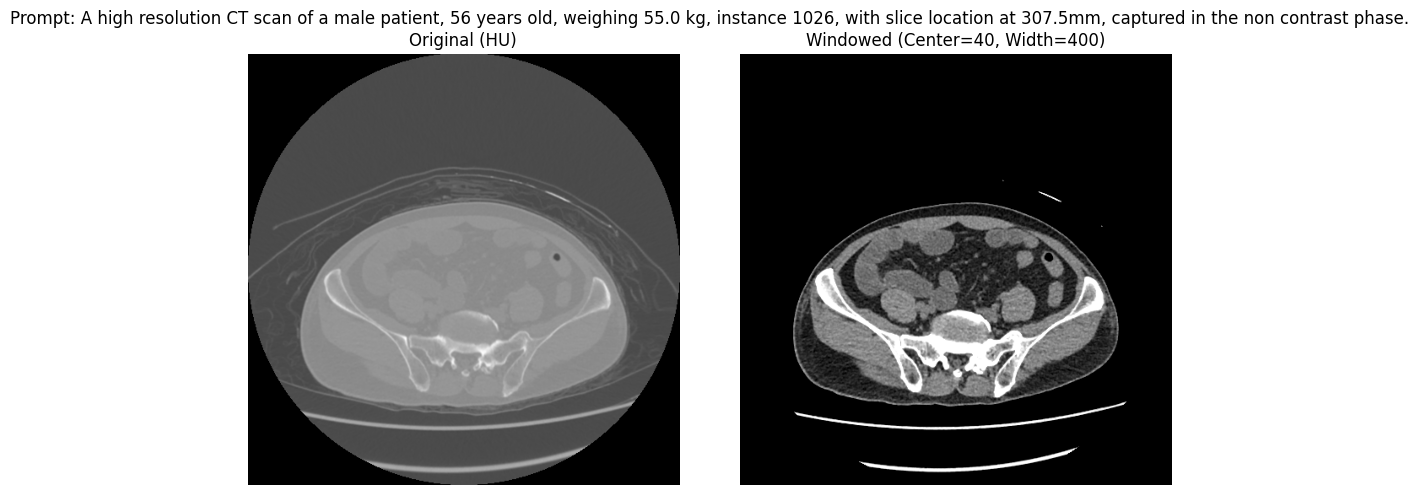

Image: ./data/vindr_multiphase/abdomen_phases/batch1/1.2.392.200036.9116.2.5.1.37.2418751871.1432695579.168588/1.2.392.200036.9116.2.5.1.37.2418751871.1432695767.136800/1.2.392.200036.9116.2.5.1.37.2418751871.1432695805.216510.dcm
  WindowCenter: 40
  WindowWidth: 400


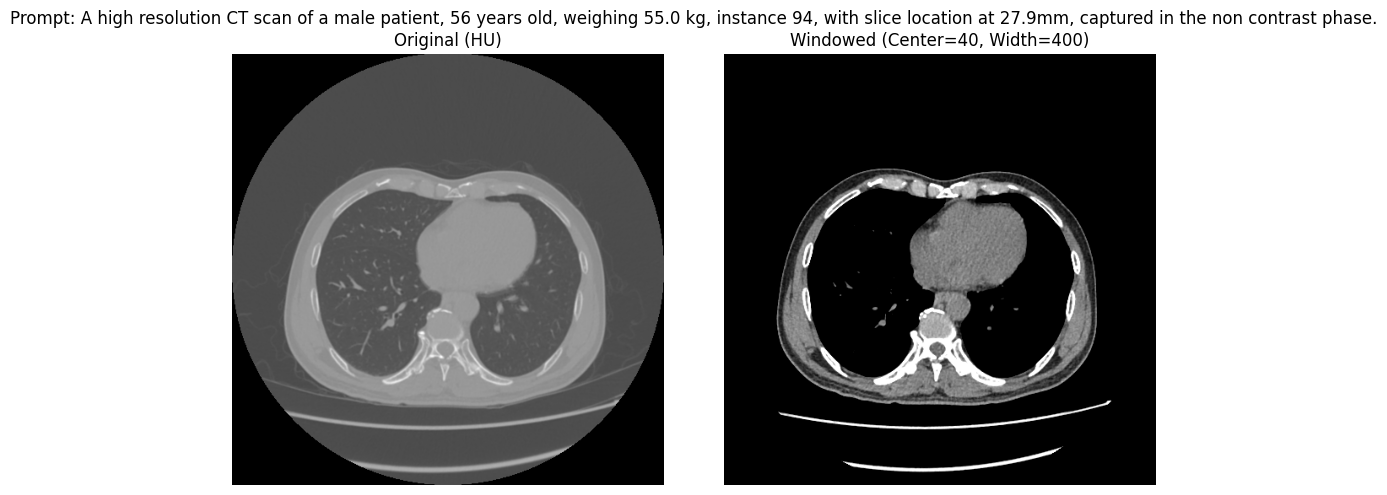

Image: ./data/vindr_multiphase/abdomen_phases/batch1/1.2.392.200036.9116.2.5.1.37.2418751871.1432695579.168588/1.2.392.200036.9116.2.5.1.37.2418751871.1432695767.136800/1.2.392.200036.9116.2.5.1.37.2418751871.1432695860.373822.dcm
  WindowCenter: 40
  WindowWidth: 400


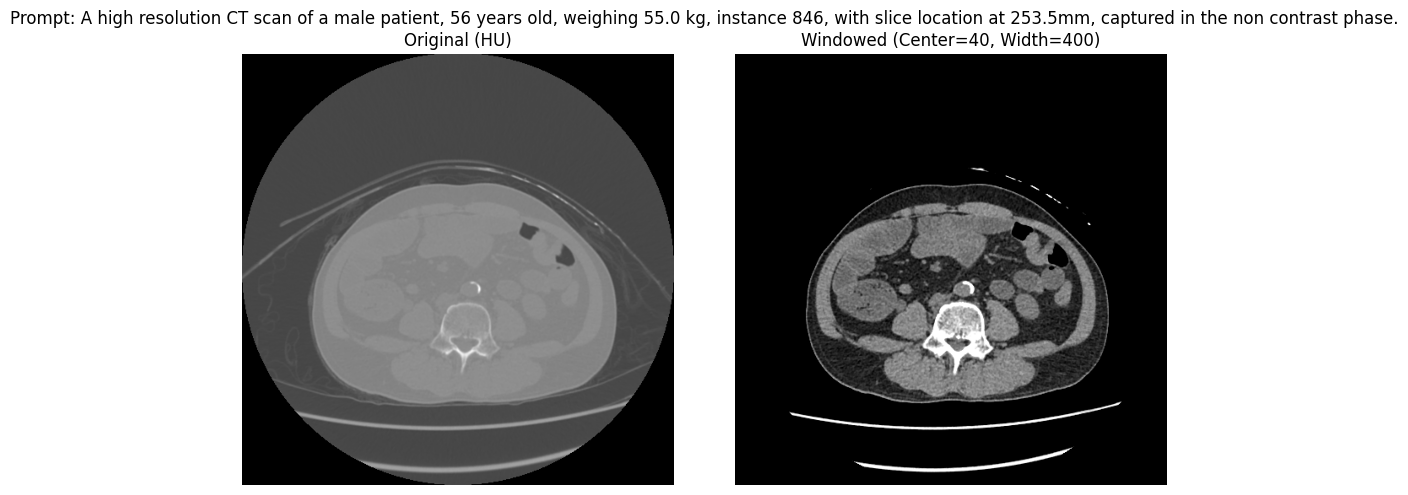

Image: ./data/vindr_multiphase/abdomen_phases/batch1/1.2.392.200036.9116.2.5.1.37.2418751871.1432695579.168588/1.2.392.200036.9116.2.5.1.37.2418751871.1432695767.136800/1.2.392.200036.9116.2.5.1.37.2418751871.1432695831.786822.dcm
  WindowCenter: 40
  WindowWidth: 400


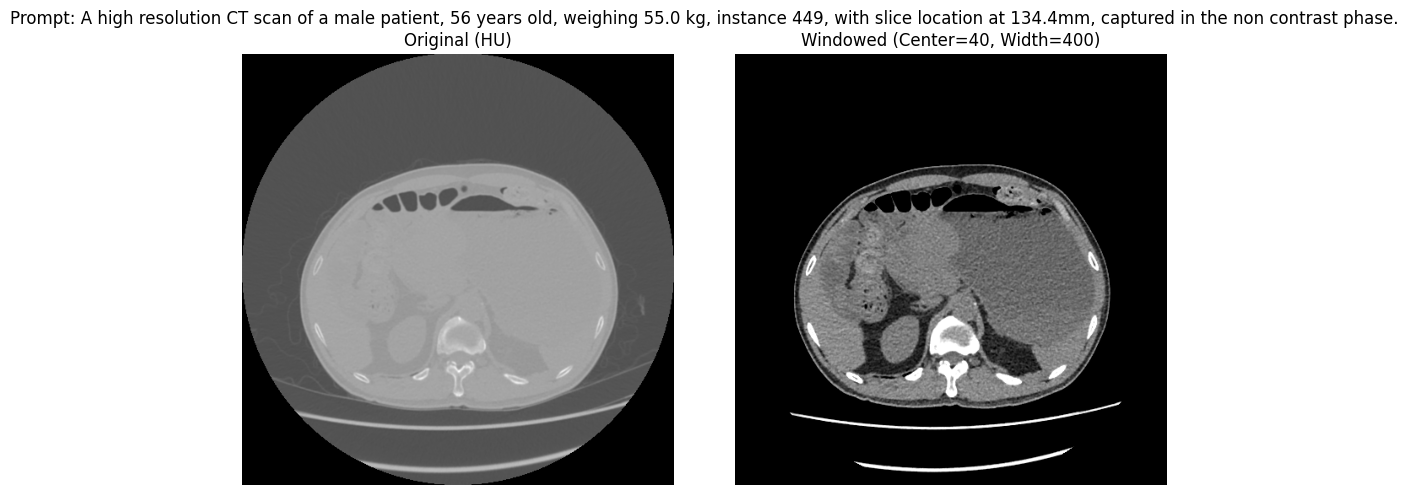

In [17]:
from pydicom.multival import MultiValue
num_samples = 5

for idx, row in metadata_prompt_df.head(num_samples).iterrows():
    dcm_path = row['image_path']
    prompt = row['prompt']
    
    full_path = os.path.join(_root, row['image_path'].lstrip("./"))
    dcm = pydicom.dcmread(full_path)

    # if isinstance(dcm.get("WindowCenter", None), MultiValue):
    #     print("WindowCenter có nhiều giá trị:", dcm.WindowCenter)
    # else:
    #     print("WindowCenter chỉ có 1 giá trị:", dcm.get("WindowCenter"))
    
    # # Kiểm tra WindowWidth
    # if isinstance(dcm.get("WindowWidth", None), MultiValue):
    #     print("WindowWidth có nhiều giá trị:", dcm.WindowWidth)
    # else:
    #     print("WindowWidth chỉ có 1 giá trị:", dcm.get("WindowWidth"))
    
    hu_img = convert_pixel_to_hu(dcm)

    print(f"Image: {dcm_path}")
    print(f"  WindowCenter: {dcm.get('WindowCenter')}")
    print(f"  WindowWidth: {dcm.get('WindowWidth')}")

    window_center = dcm.get('WindowCenter', 40)
    window_width = dcm.get('WindowWidth', 400)

    windowed_img = apply_window(hu_img, window_center, window_width)

    # Plot hình ảnh
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(hu_img, cmap='gray')
    axs[0].set_title("Original (HU)")
    axs[0].axis('off')

    axs[1].imshow(windowed_img, cmap='gray')
    axs[1].set_title(f"Windowed (Center={window_center}, Width={window_width})")
    axs[1].axis('off')

    plt.suptitle(f"Prompt: {prompt}", fontsize=12)
    plt.tight_layout()
    plt.show()

# Statistics

In [18]:
def plot_pie_charts(df, columns=['PatientSex', 'PatientAge', 'PatientWeight', 'ContrastBolusAgent', 'Label']):
    num_cols = len(columns)
    rows = math.ceil(num_cols / 2)  # Arrange in 2 columns
    fig, axes = plt.subplots(rows, 2, figsize=(12, 6 * rows))
    axes = axes.flatten()
    
    for i, col in enumerate(columns):
        counts = df[col].value_counts(dropna=False)  # Include NaN values
        labels = counts.index.astype(str).tolist()
        labels = [label if label != 'nan' else 'NaN' for label in labels]  # Rename NaN for clarity
        
        axes[i].pie(
            counts, 
            labels=labels, 
            autopct='%1.1f%%', 
            startangle=90, 
            colors=plt.cm.Paired.colors
        )
        axes[i].set_title(f'{col} Distribution')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

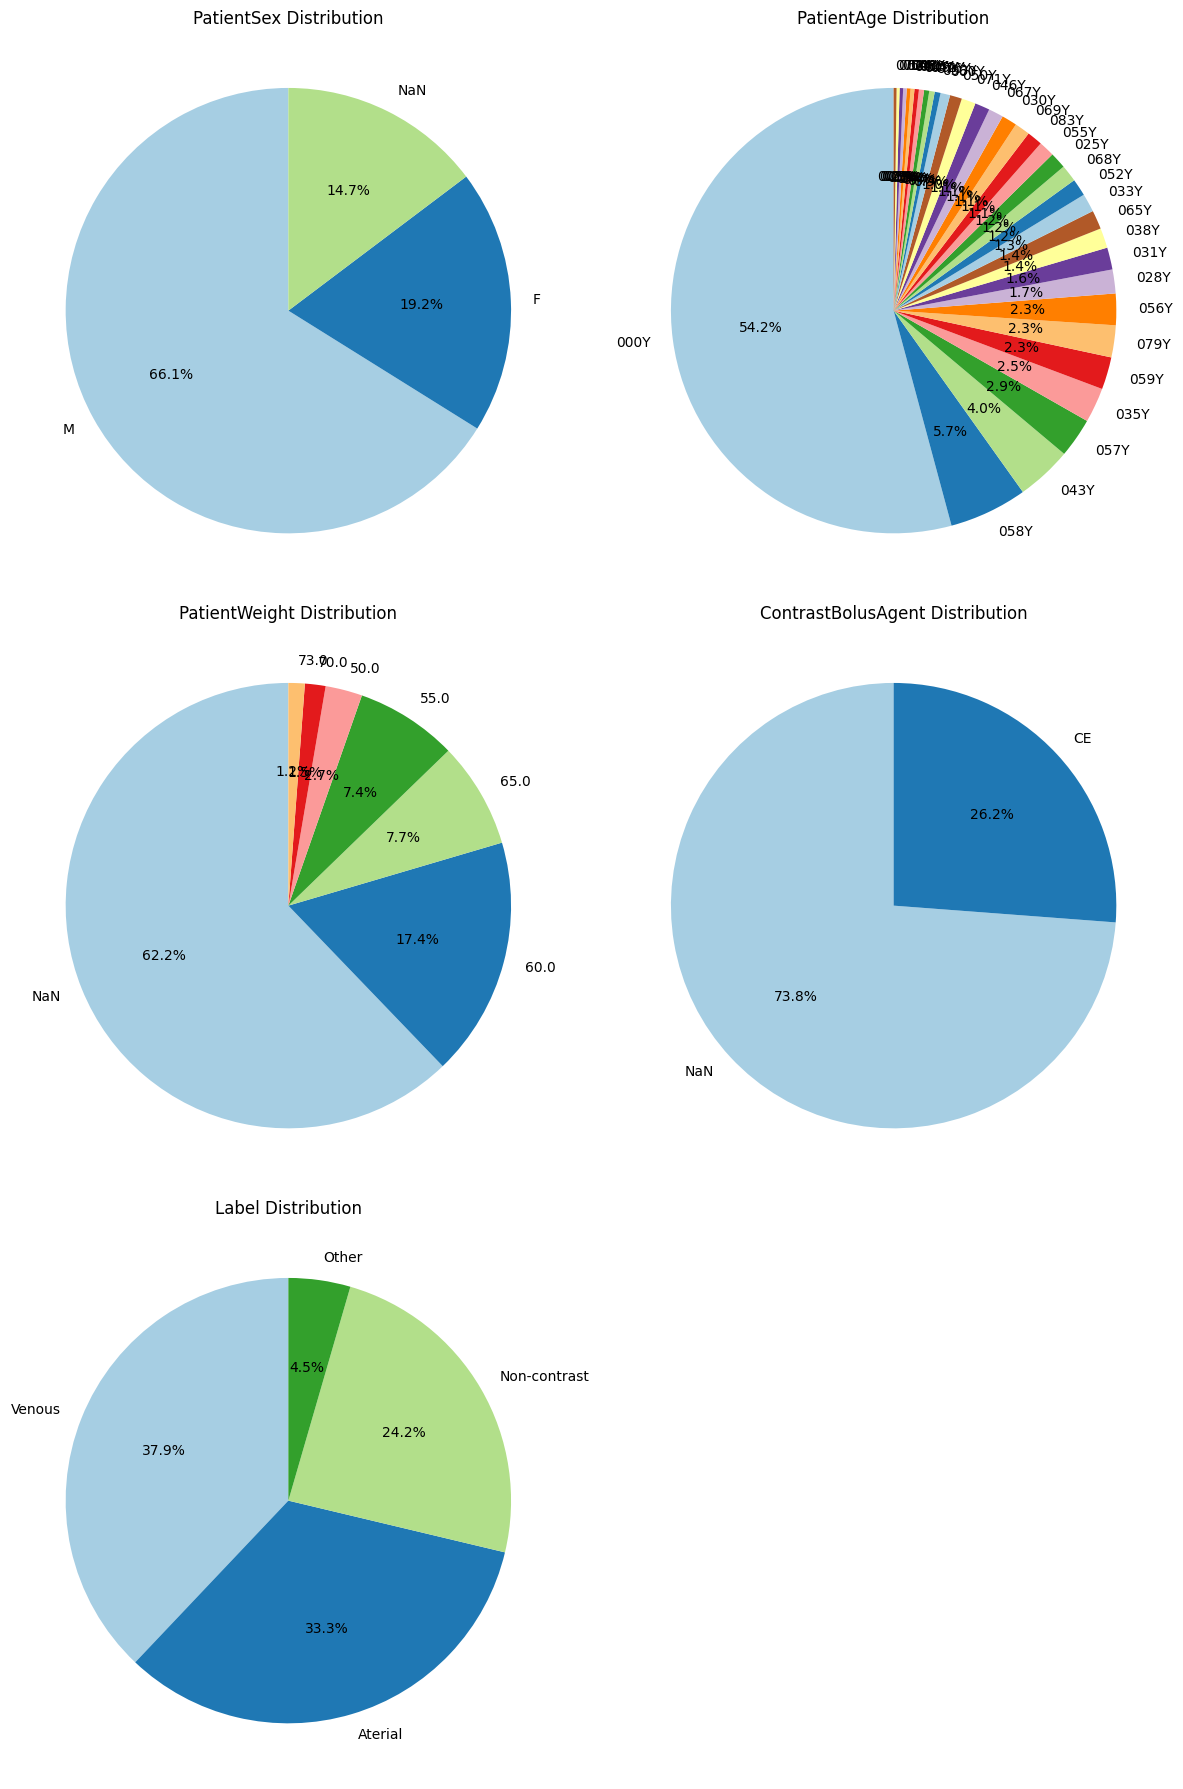

In [19]:
plot_pie_charts(merged_df)

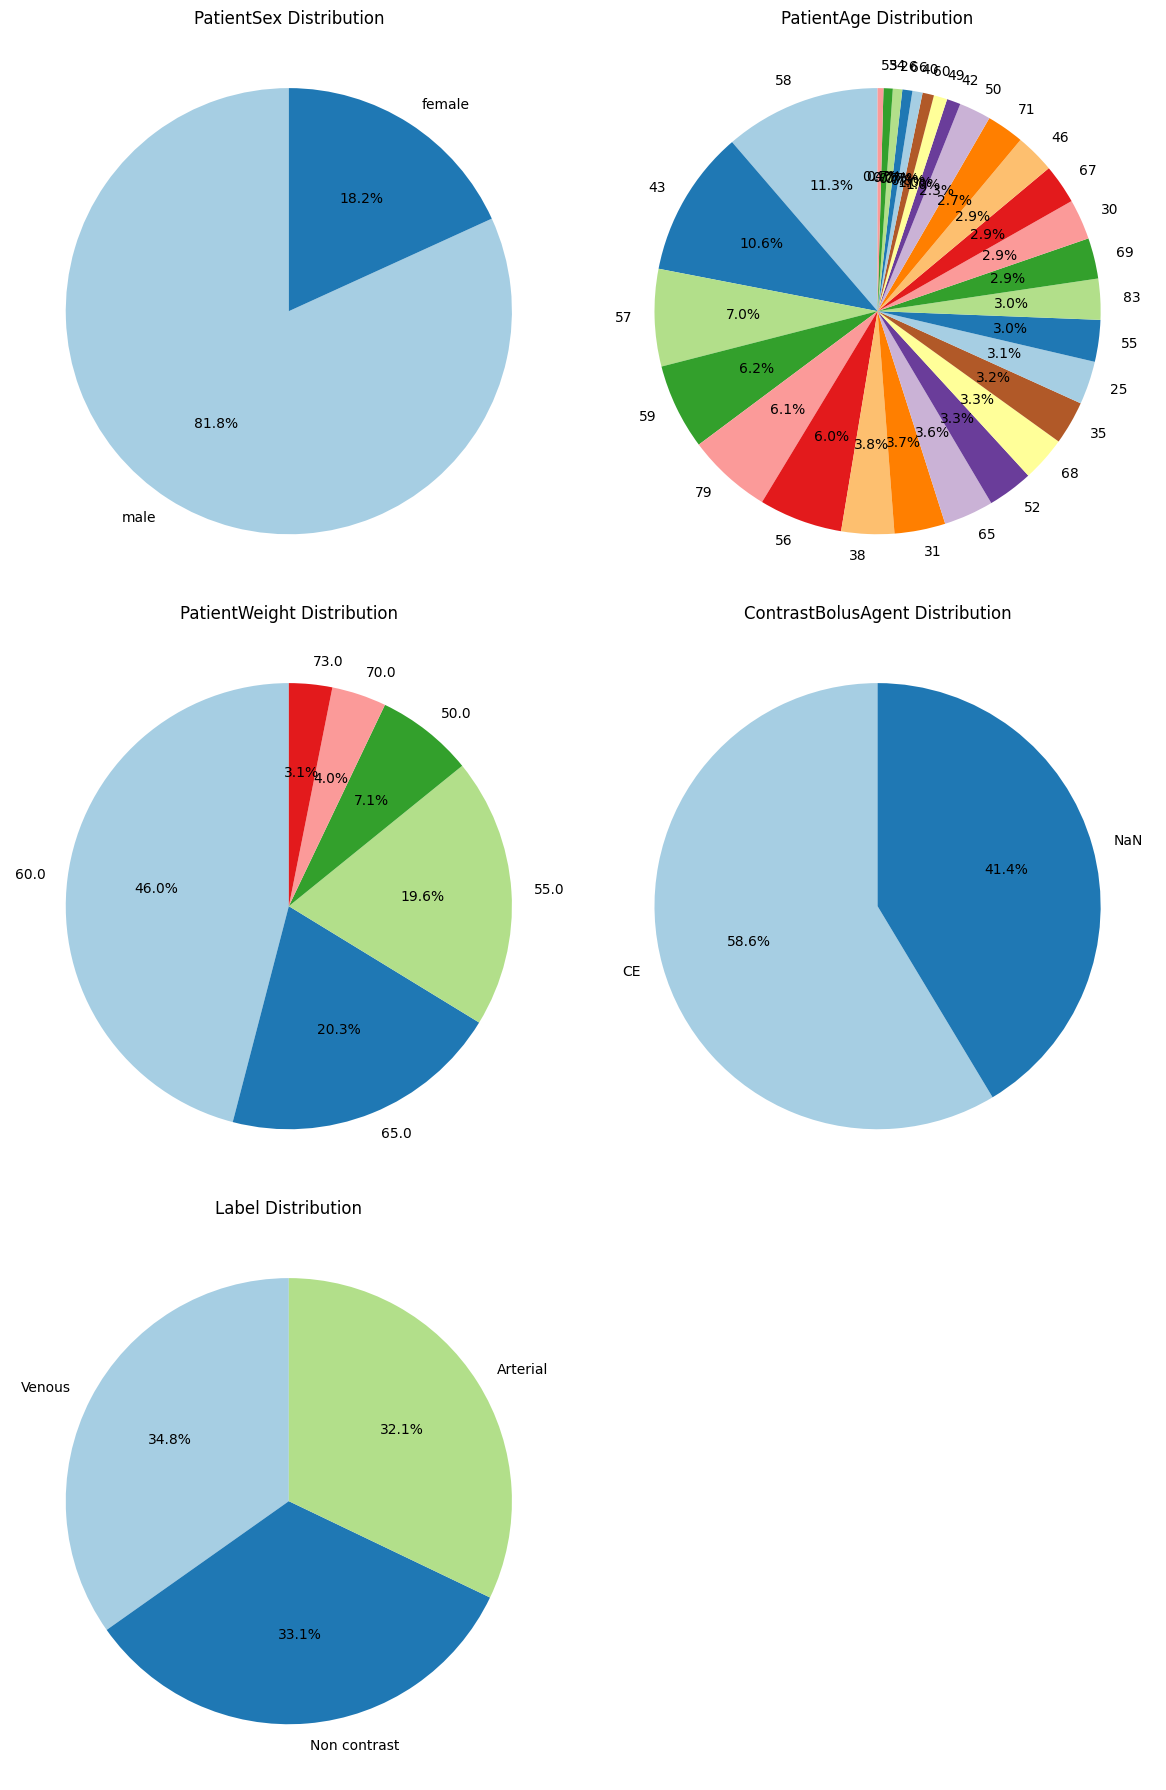

In [20]:
plot_pie_charts(metadata_prompt_df)

In [21]:
def plot_slice_statistics(df, group_col='SeriesInstanceUID', slice_col='InstanceNumber', bins=100):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Distribution of Number of Slices per CT Scan
    slice_counts = df.groupby(group_col)[slice_col].nunique()
    sns.histplot(slice_counts, bins=bins, kde=True, color='skyblue', ax=axes[0])
    axes[0].set_title(f'Distribution of Number of Slices per {group_col}')
    axes[0].set_xlabel('Number of Slices per CT Scan')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Frequency of InstanceNumber
    sns.histplot(df[slice_col], bins=bins, kde=True, color='salmon', ax=axes[1])
    axes[1].set_title(f'Frequency Distribution of {slice_col}')
    axes[1].set_xlabel(slice_col)
    axes[1].set_ylabel('Frequency')
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

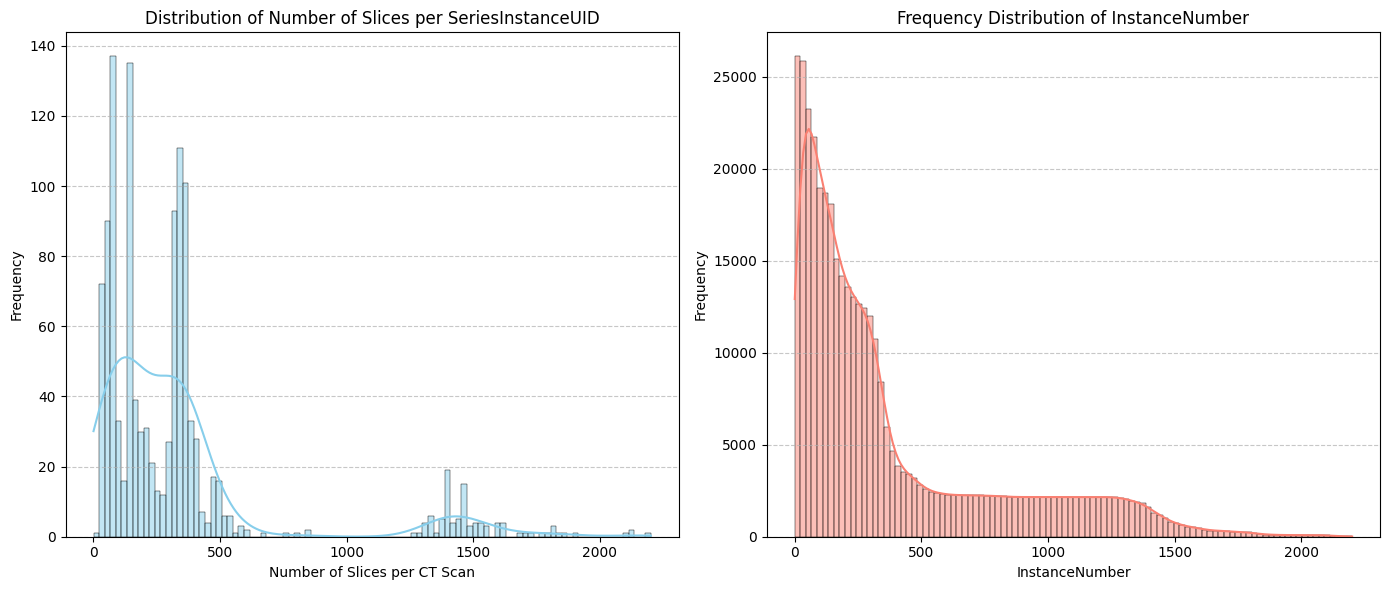

In [22]:
plot_slice_statistics(merged_df)

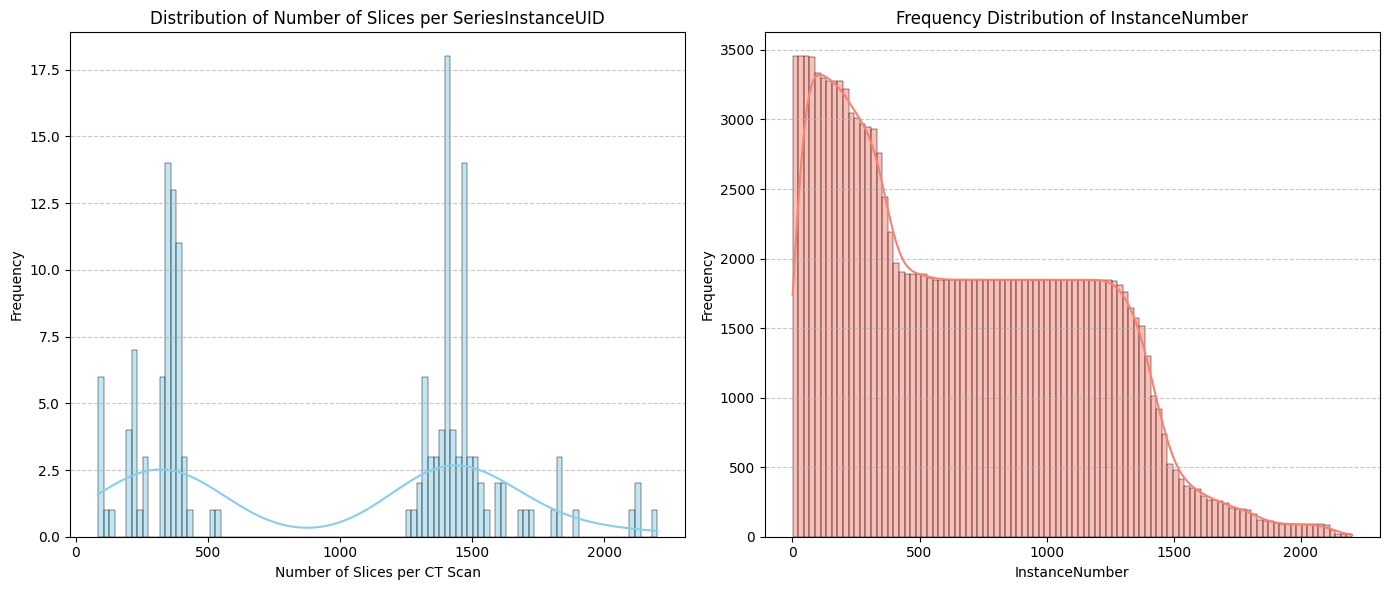

In [23]:
plot_slice_statistics(metadata_prompt_df)